# Numerical expression inference problem: the GEP-RNC algorithm
In this example, we aim to identify a mathematicalfunction $f$ from the given input-ouput data such that the function $f$ can produce the expected ouput given a certain input. This is a typical [symbolic regression](https://en.wikipedia.org/wiki/Symbolic_regression) problem:

> Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity.

which is most commonly solved with genetic programming and its variant, gene expression programming (GEP), presented here. 

Before continuing this example, you'd better first go through the two fundamental tutorials listed below to get familiar with GEP and *geppy*:
+ [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html)
+ [Overview of geppy for Gene Expression Programming (GEP)](https://geppy.readthedocs.io/en/latest/overview.html)

The main difference of this problem w.r.t the [Boolean function identification](Boolean_function_identification.ipynb) problem is that generally a mathematical model involves constant coefficients, which is more challenging for both genetic programming (GP) and GEP. The standard way to handle numerical constants in GEP is to add another Dc domain in the genes dedicated to random numerical constant (RNC) evolution, i.e., the GEP-RNC algorithm. Please check Chapter 5 of *Ferreira, Cândida. Gene expression programming: mathematical modeling by an artificial intelligence. Vol. 21. Springer, 2006.* to learn more about the theory.

Alternatively, if the involved numerical constants are just simple integers, then the traditional ephemeral numerical constant (ENC) method can also be used, though it is not recommended in GEP. See the example [ENC for numerical expression inference](./numerical_expression_inference-ENC.ipynb).

To check the detailed documentation of each function/class in *geppy*, please refer to [library reference](https://geppy.readthedocs.io/en/latest/#library-reference).

In [29]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

# Synthetic dataset

For this simple task, we first choose a ground truth function $f$ to generate a dataset $D$. Then, 50 input-output exampels are generated randomly.

In [30]:
def f(x):
    """Ground truth function"""
    return -2 * x ** 2 + 11 * x + 13

In [31]:
n_cases = 100
X = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X) + np.random.normal(size=n_cases) # Gaussian noise

# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this problem, we have:
+ function set: the standard arithmetic operators addition (+), subtraction (-), multiplication (*), and division (/).
+ terminal set: only the single input 'x' and random numerical constants (RNC).

NOTE:

- We define a *protected division* to avoid dividing by zero.
- Even there may be multiple RNCs in the model, we only need to call `PrimitiveSet.add_rnc` once.

In [32]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [33]:
import operator 

pset = gep.PrimitiveSet('Main', input_names=['x'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_rnc_terminal()

# Create the individual and population
Our objective is to **minimize** the MSE (mean squared error) for data fitting.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [34]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length: 6
+ number of genes in each chromosome: 2
+ RNC array length: 8

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes. **The most important is that we should use the `GeneDc` class for genes to make use of the GEP-RNC algorithm.**

In [35]:
h = 6 # head length
n_genes = 2   # number of genes in a chromosome
r = 8   # length of the RNC array

In [36]:
toolbox = gep.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-5, b=5)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(-1,)`` when creating the ``FitnessMax`` class.

In [37]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X)))
    return np.mean(np.abs(Y - Yp)),

In [38]:
toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selTournament`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [39]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.3)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.05, pb=1)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)
toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)
# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.5p')
toolbox.pbs['mut_rnc_array_dc'] = 1  # we can also give the probability via the pbs property

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [40]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_rnc`` here to perform the GEP-RNC evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [41]:
# size of population and number of generations
n_pop = 100
n_gen = 100

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	100   	81.9249	27.7577	54.9895	261.298
1  	99    	71.8922	10.4668	42.0433	136.346
2  	99    	89.6798	205.708	38.9218	2131.62
3  	99    	69.0112	17.4721	28.2459	165.384
4  	99    	66.6045	16.1314	27.3629	120.876
5  	99    	87.5899	169.74 	14.3539	1728.69
6  	99    	62.2542	27.1422	14.3539	225.294
7  	99    	58.4688	29.2628	14.3539	228.513
8  	99    	61.5411	43.0892	10.8169	320.429
9  	99    	76.703 	96.8616	7.82959	905.788
10 	99    	65.6228	52.688 	7.23691	350.552
11 	99    	52.7719	42.748 	7.23691	390.783
12 	99    	52.6757	32.2696	6.19445	196.143
13 	99    	58.4056	67.1411	6.19445	603.211
14 	99    	54.7206	43.1564	6.19445	384.694
15 	99    	61.7266	57.6286	6.19445	562.3  
16 	99    	62.236 	64.4507	6.19445	553.836
17 	99    	54.2323	26.7546	5.20662	126    
18 	99    	57.36  	36.9686	5.20662	190.35 
19 	99    	55.89  	43.3556	5.20662	391.671
20 	99    	55.3062	33.5315	5.20662	196.9  
21 	99    	64.8551	67.2205	5.20662	461.723
22 	99    	

**Let's check the best individuals ever evolved.**

In [42]:
print(hof[0])

add(
	mul(sub(add(x, x), sub(-4, -3)), sub(5, x)),
	sub(add(sub(-3, -5), sub(x, -4)), sub(-2, x))
)


# *[optional]* Post-processing: simplification and visualization
## Symbolic simplification of the final solution
The original solution seems a little complicated, which may contain many redundancies, for example, `protected_div(x, x)` is just 1. We can perform symbolic simplification of the final result by `geppy.simplify` which depends on `sympy` package.

In [43]:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
-2*x**2 + 11*x + 13


As we can see from the above simplified expression, the *truth model* has been successfully found. Due to the existence of Gaussian noise, the minimum mean absolute error （MAE) is still not zero even the best individual represents the true model.

## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

In [44]:
 # we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

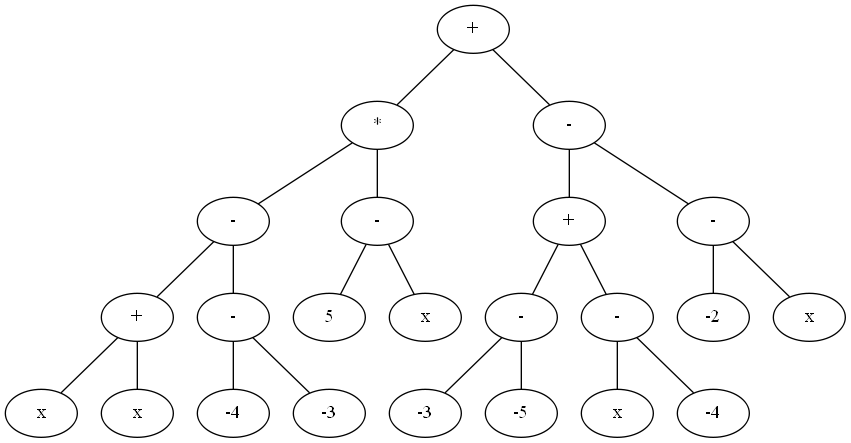

In [45]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png') 

# Discussion
If only integer constants are involved, then the GEP-RNC algorithm is very effective. If the constants are general real numbers, then more advanced techniques like local search may be more suitable.

Alternatively, the ephemeral numerical constant (ENC) based method can also be adopted here. Please check [ENC for numerical expression inference](./numerical_expression_inference-ENC.ipynb).
